In [1]:
# WEC Podium Prediction Model
# Coded by Kavin Vasudevan, Sidharth Bansal, Murtaza Shiyaji

In [2]:
#Kaggle Link: https://www.kaggle.com/datasets/tristenterracciano/fia-wec-lap-data-20122022
import kagglehub
import os
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

### Loading the dataset from the kaggle API

In [3]:
path = kagglehub.dataset_download("tristenterracciano/fia-wec-lap-data-20122022")
files = os.listdir(path)
print(files)

['2012-2022_FIA_WEC_FULL_LAP_DATA.csv']


In [4]:
dataframes = {}
for filename in os.listdir(path):
  if filename.endswith(('.csv', '.txt')):
    file_path = os.path.join(path, filename)
    try:
        df = pd.read_csv(file_path, low_memory=False)
    except pd.errors.ParserError:
        try:
            df = pd.read_table(file_path)
        except pd.errors.ParserError:
            print(f"Skipping file {filename}: Could not parse as CSV or TXT")
            continue
    dataframes[filename] = df


### Helper functions

In [5]:
def add_finishing_positions(group):
    team_summary = group.groupby('team_no', as_index=False).agg({
        'laps_completed': 'max',
        'last_position': 'min'
    })
    team_summary = team_summary.sort_values(by=['laps_completed', 'last_position'], ascending=[False, True])
    team_summary['ending_rank'] = range(1, len(team_summary) + 1)
    group = group.merge(team_summary[['team_no', 'ending_rank']], on='team_no', how='left')

    return group

### Data Preprocessing

#### Creating the 'start_position' and 'podium' columns

In [6]:
start_finish = df[["season", "circuit", "class", "lap_number", "team_no", "class_position"]]

grouped = start_finish.groupby(['season', 'circuit', 'class', 'team_no'])

starting_positions = grouped.apply(
    lambda x: x.loc[x['lap_number'].idxmin(), 'class_position'],
    include_groups=True
).reset_index(name='starting_position')

with_starting = start_finish.merge(starting_positions, on=['season', 'circuit', 'class', 'team_no'])

laps_completed = grouped['lap_number'].max().reset_index(name='laps_completed')
with_laps_completed = with_starting.merge(laps_completed, on=['season', 'circuit', 'class', 'team_no'])

last_positions = grouped.apply(
    lambda x: x.loc[x['lap_number'].idxmax(), ['class_position', 'lap_number']],
    include_groups=True
).reset_index()

last_positions.columns = ['season', 'circuit', 'class', 'team_no', 'last_position', 'last_lap']
with_laps_completed = with_laps_completed.merge(last_positions, on=['season', 'circuit', 'class', 'team_no'])

with_start_finish = with_laps_completed.groupby(
    ['season', 'circuit', 'class'], 
    group_keys=False
).apply(add_finishing_positions, include_groups=True)

with_start_finish['podium'] = with_start_finish['ending_rank'].apply(lambda x: 1 if 1 <= x <= 3 else 0)

df = with_start_finish.merge(
    df,
    on=['season', 'circuit', 'class', 'team_no', 'lap_number', 'class_position'],
    how='left'
)

/var/folders/0_/t3z84yg56j388w97fz88nfqc0000gn/T/ipykernel_17858/2137416212.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  starting_positions = grouped.apply(
/var/folders/0_/t3z84yg56j388w97fz88nfqc0000gn/T/ipykernel_17858/2137416212.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  last_positions = grouped.apply(
/var/folders/0_/t3z84yg56j388w97fz88nfqc0000gn/T/ipykernel_17858/2137416212.py:26: FutureWarnin

#### Dropping unnecessary columns:
number, driver_number, lap_improvement, crossing_finish_line_in_pit, s1_improvement, s2_improvement, s3_improvement, elapsed, hour, s1_large, s2_large, s3_large, driver_name, pit_time, group, team, round, vehicle, flag_at_fl, lap_time, lap_time_ms, lap_time_s, engine, driver_stint_no, driver_stint, team_stint, elapsed_ms, position, interval_ms, interval, gap, class_interval, class_gap, elapsed_s


In [7]:
columns = [
    "number", "driver_number", "lap_improvement", "crossing_finish_line_in_pit",
    "s1_improvement", "s2_improvement", "s3_improvement", "elapsed", "hour",
    "s1_large", "s2_large", "s3_large", "driver_name", "pit_time", "group",
    "team", "round", "vehicle", "flag_at_fl", "lap_time", "lap_time_ms", "lap_time_s",
    "engine", "driver_stint_no", "driver_stint", "team_stint", "elapsed_ms",
    "position", "interval_ms", "interval", "gap", "class_interval",
    "class_gap", "elapsed_s",
    "class_position", "laps_completed", "last_position", "last_lap", "ending_rank", "Unnamed: 0"
]

df.drop(columns, inplace=True, axis=1)

#### Fill in NA values with averages based on the specific season, circuit, and class

In [8]:
for col in ['s1', 's2', 's3', 'top_speed']:
  df[col] = df.groupby(['season', 'circuit', 'class'])[col].transform(lambda group: group.fillna(group.mean()))

#### Merging each driver's laps into 1 single row

In [9]:
merged_df = df.groupby(['season', 'circuit', 'class', 'team_no', 'starting_position', 'podium', 'manufacturer'], as_index=False).agg(
    {
    's1': 'mean',
    's2': 'mean',
    's3': 'mean',
    'kph': 'mean',
    'top_speed': 'mean',
    'team_stint_no': 'max'
    })

#### Normalizing start position

In [10]:
merged_df['normalized_starting_position'] = (
    merged_df.groupby(['season', 'circuit', 'class'])['starting_position']
    .transform(lambda x: (x - x.min()) / (x.max() - x.min()))
)

merged_df.drop('starting_position', axis=1, inplace=True)

#### Creating the "speed_efficiency" column

In [11]:
merged_df["speed_efficiency"] = merged_df["kph"] / merged_df["top_speed"]

#### Splitting into training and testing data

In [12]:
train_data = merged_df[merged_df['season'] != "2022"].copy()
test_data = merged_df[merged_df['season'] == "2022"].copy()

#### Drop 'season' and 'team_no'

In [13]:
train_data.drop(['season', 'team_no'], axis=1, inplace=True)
test_data.drop(['season', 'team_no'], axis=1, inplace=True)

### Model Creation

In [14]:
features = ['circuit', 'class', 'manufacturer', 's1', 's2', 's3', 'kph', 'top_speed', 'team_stint_no', 'normalized_starting_position', 'speed_efficiency']
target = 'podium'

le = LabelEncoder()
for col in ['circuit', 'class', 'manufacturer']:
    train_data[col] = le.fit_transform(train_data[col])
    test_data[col] = le.transform(test_data[col])

scaler = StandardScaler()
numerical_features = ['s1', 's2', 's3', 'kph', 'top_speed', 'team_stint_no', 'speed_efficiency']
train_data[numerical_features] = scaler.fit_transform(train_data[numerical_features])
test_data[numerical_features] = scaler.transform(test_data[numerical_features])

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

X_train = X_train.dropna(axis=0)
y_train = y_train.loc[X_train.index]
X_test  = X_test.dropna(axis=0)
y_test  = y_test.loc[X_test.index]

model = RandomForestClassifier(random_state=42, n_estimators = 150, max_depth=30, bootstrap=True, criterion="log_loss")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.80      0.92      0.85        98
           1       0.62      0.36      0.46        36

    accuracy                           0.77       134
   macro avg       0.71      0.64      0.65       134
weighted avg       0.75      0.77      0.75       134

0.7686567164179104


### Model visualization and results

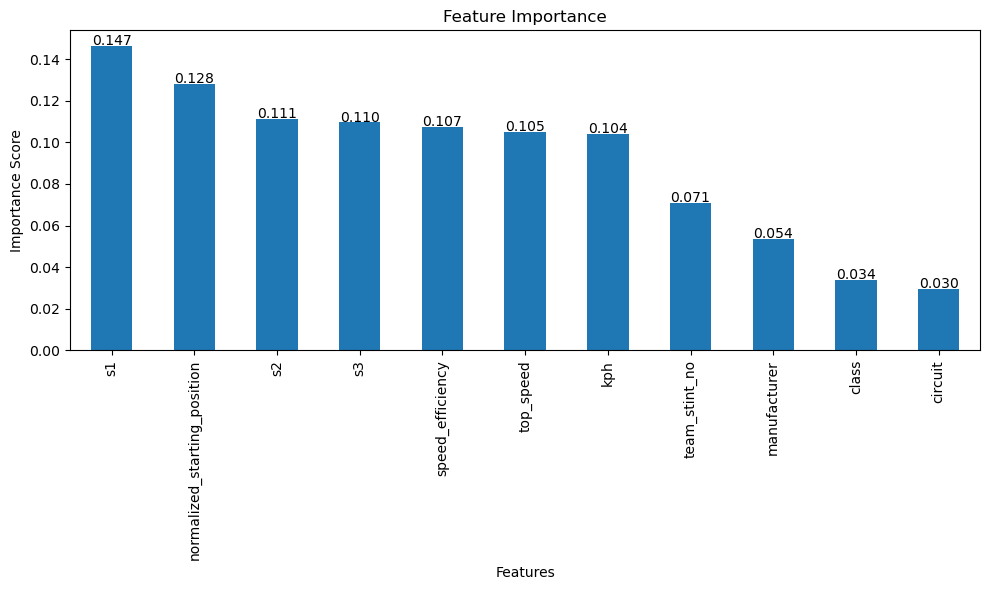

In [15]:
importances = model.feature_importances_
indices = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
indices.plot(kind='bar')

for i, value in enumerate(indices):
    plt.text(i, value - 0.001, f"{value:.3f}", ha='center', va='bottom', fontsize=10)

plt.title("Feature Importance")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

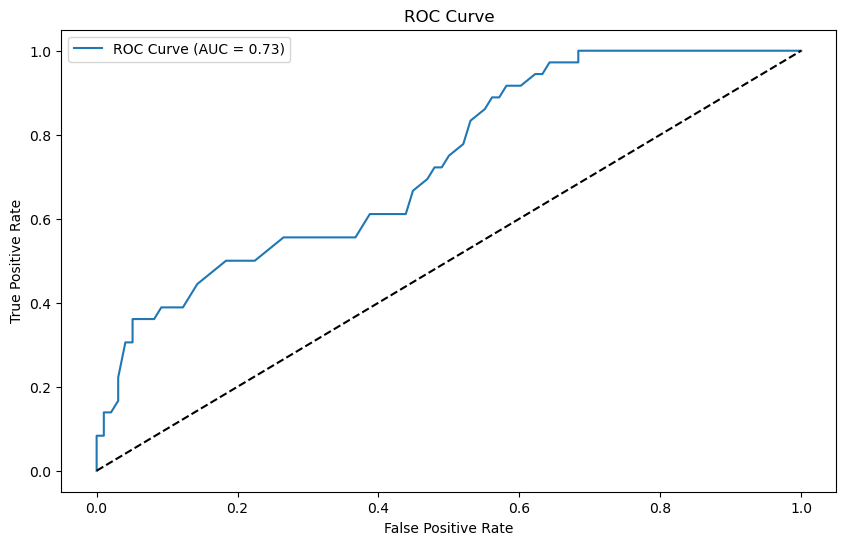

In [16]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


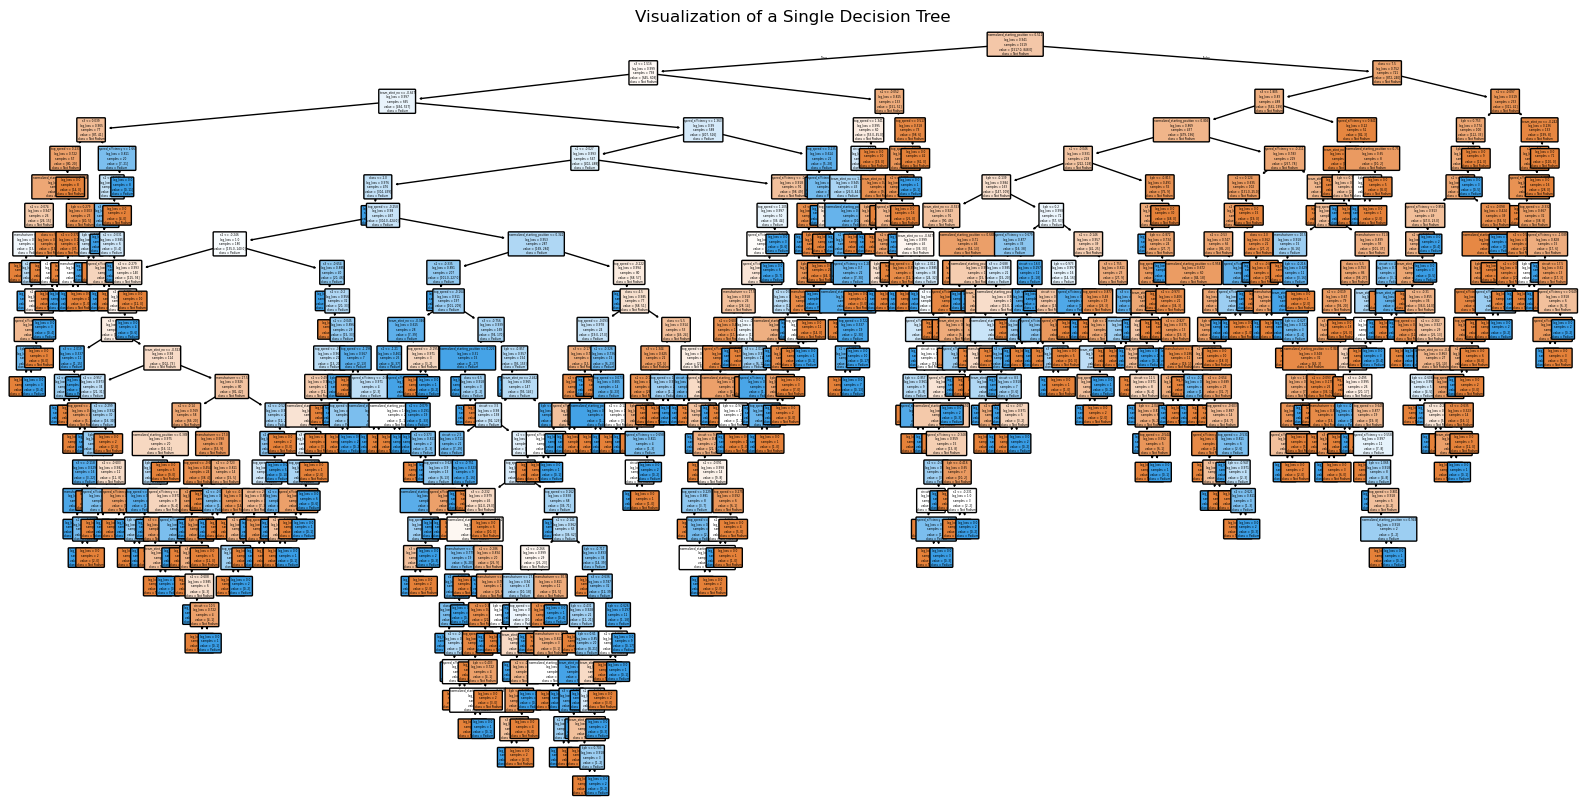

In [17]:
plt.figure(figsize=(20, 10))
plot_tree(model.estimators_[0],
          feature_names=features,
          class_names=['Not Podium', 'Podium'],
          filled=True,
          rounded=True,
          fontsize=2)
plt.title("Visualization of a Single Decision Tree")
plt.show()